In [18]:
options(warn=-1)
library(ggplot2)
library(tidydata)
library(tidydata)
library(ggextra)
set.seed(6203)

ERROR: Error in library(tidydata): there is no package called ‘tidydata’


## Team Members

* Aaditya Vinnakota (Aaditya316) 
* Bao Vo (baovo022293) 
* Frank Corrao (fcorrao) 
* Michael Obin (Obin_michael)
* Nicholas Coyle (nscoyle) 

## Project Overview

### Goals

The goal of our analysis is to identify stock attributes and performance trends which are indicative of resilience during economic downturns. To do so, we leverage data for securities in the S&P 500 during several ‘down markets’ - identifying the stocks which outperform the market and analyzing the traits they have in common (e.g. industry, company size, etc). 

### Approach 

The metric we use to identify outperformance is Jensens Alpha.  We run a standard Jensen's Alpha regression:





For each period, we identify the top 30% of positive alpha stocks and code them as outperformers.  This output beceomes the target of a 
logistic regression to identify features predective of that good performance:




Variables that survive backwards-selection and are statistically significant will be deemed features that predict outperformance.


### Initial Hypothesis / Literature Review

Through this research, we have formed several hypotheses about which types of companies might outperform in recession. We have identified two papers, (Woszczyk 2019) and (Ozkan 2009), which explore investment strategy during economic downturns. Researchers suggest that ‘vice stocks’ tend to outperform as folks resort to ‘bad habits’ (e.g. drinking, smoking, gambling) during times of unemployment Sources 2 (Ozkan 2009).
They also find that healthcare companies are resilient, as demand can be relatively inelastic for medical care (Woszczyk 2019).

## Overview of Data

Most of the data for this analysis was from sources that were relatively clean. The key componets we needed for the analysis:

* For identifying outperformers
  * Data to identify recessionary periods
  * Stock and index returns
  * Index components
* For identiying attributes that predict outperformance
  * Stock specific attributes (industry, common factor exposures, etc)
  * Macroeconomic factors

### Identifying recessions

We observice market performance during several recession periods in the United States as idenfitied by the [Federal Reserve GDP based recession indicator](https://fred.stlouisfed.org/series/JHDUSRGDPBR).

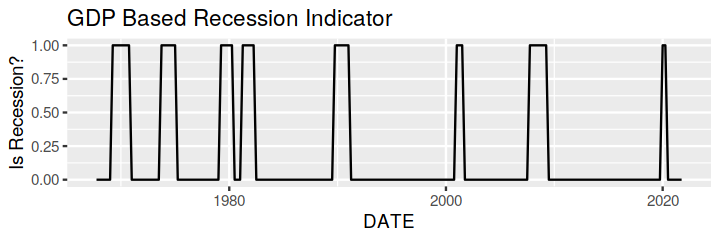

In [23]:
options(repr.plot.width=6, repr.plot.height=2)
is_recession <- read.csv('../Data/JHDUSRGDPBR.csv')
is_recession$DATE <- as.Date(is_recession$DATE)
ggplot(is_recession, aes(x=DATE,y=JHDUSRGDPBR)) + geom_line() + ylab('Is Recession?') + ggtitle("GDP Based Recession Indicator") 

Due to limitations in access to historical data, we evalute performance to the three most recent recessions:

* January 2001 - October 2001
* December 2007 - June 2009
* January 2020 - September 2020

### Stock returns

Corporate action adjusted stock and index prices were pulled from yahoo via the tidyquant R package. From this data, monthly returns were calculated.  S&P500 Index components were idenfied from publicly available sources.

### Stock specific attributes and Macroeconomic factors

Stock sectors were pulled from Yahoo via tidyquant.  Macroeconomic factors such as interest rate and unemployment rate were pulled from Federal Reserve Bank of St. Louis (FRED), also via tidyquant. 

## Overview of Modeling

### Identifying outperformers

Identifying companies that do well in absolute return space during the peak to through phase of a business cycle is difficult. It may be the case that the vast majority of stocks are losers, simply due to exposure to market beta. Instead, we focus on identifying those companies that outperform the market, which could easily form the basis of a market neutral strategy. The metric we use to identify outperformance is Jensens Alpha. We run a standard Jensen's Alpha regression:


We run this regression for S&P500 stocks for each recession period available to us, with the S&P500 return in placeof the market return.  Fitted alpha values are mapped to class labels {outpeformer/Not outperformer} by finding the cutoff for the top 30% percentile alpha in each period, marking everything above that cutoff that is positive as an Outperformer.  A threshold above the median was selected through exploratory analysis showing that this cutoff gave consistently positive returns of > 2%, which should be enough to cover implentation costs and buffer against regression standard errror. With these labels now in place, we can now use our outperformers in a classifier.  

### Identifying predictors of outperformance

With our coded outperformers over multiple recessionary periods in hand, we have a target to train a classifer on. We chose a logistic regression for its relatively good performance and interpertability.

There is a long list of possible factors that could predict market returns, but our imagination is limted by our data as we could not secure access to a professional quality source of equities data.  Some of the features we were able to consider are:


* Trailing 12 month returns 
* Trailing 12 month volatility
* Company sector
* Average unemployment rate in the period
* Interest rates in the period

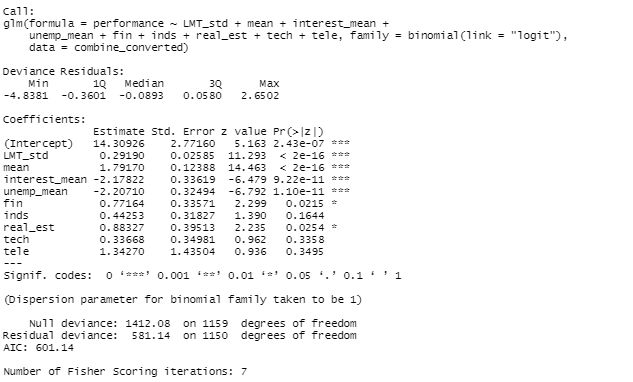

In [33]:
library(IRdisplay)
display_png(file="../Visualizations/regression_1.png", height=600, width=400)
#![image.PONWP1.png](../Visualizations/regression_1.png)

We perform backwards-selection to remove some insignicant variables to get a final regression output

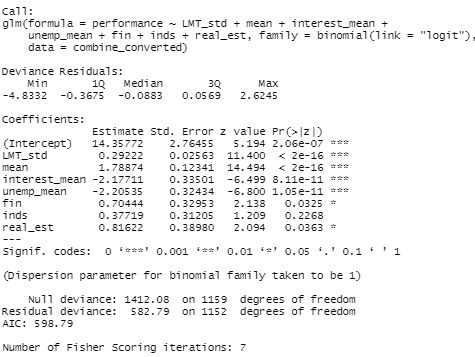

In [34]:
display_png(file="../Visualizations/regression_2.png", height=600, width=400)

## Outperformance Group Vs. Market During Each Period

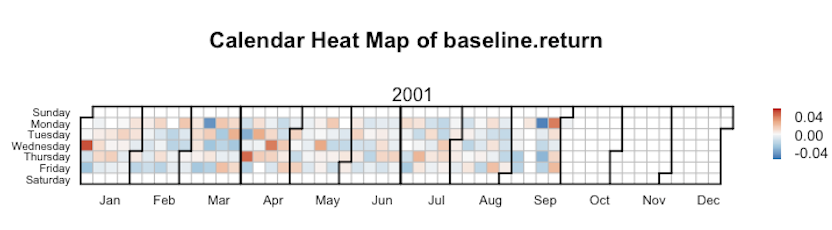

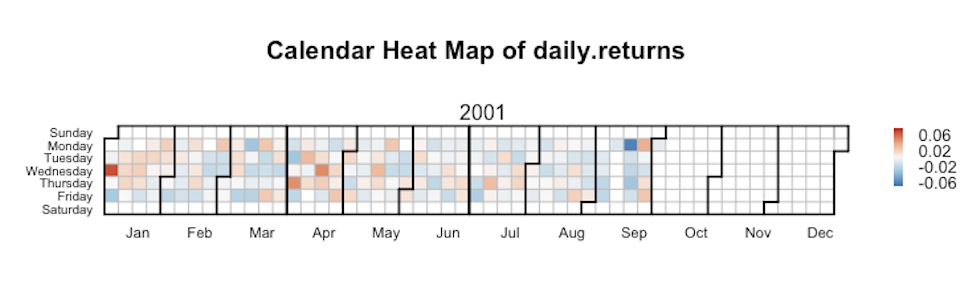

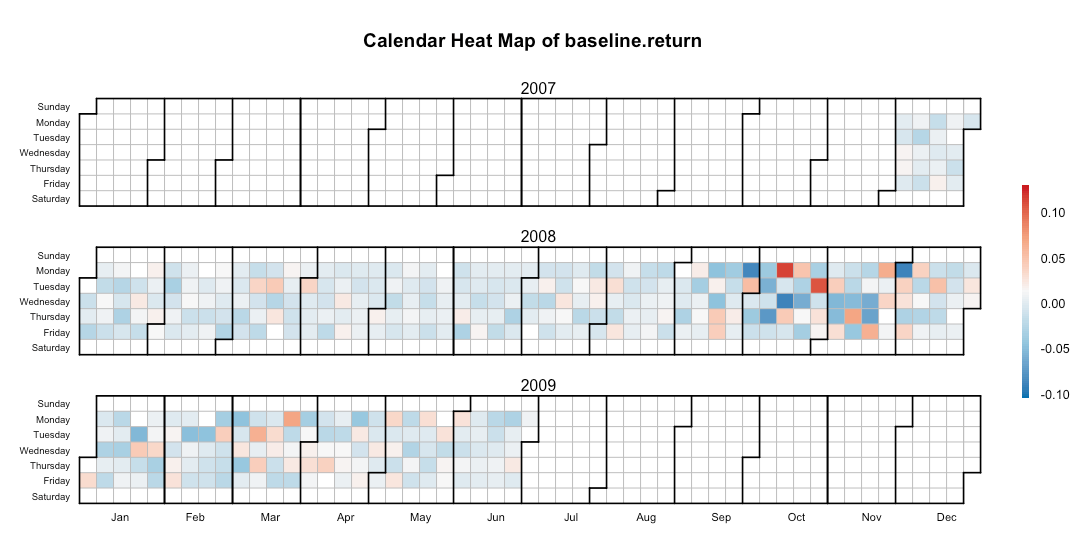

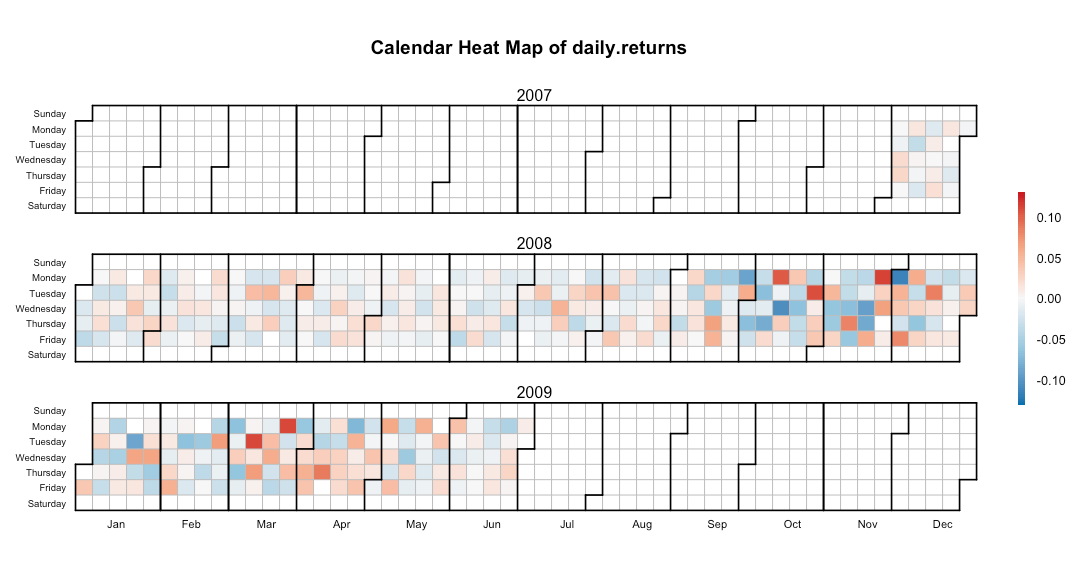

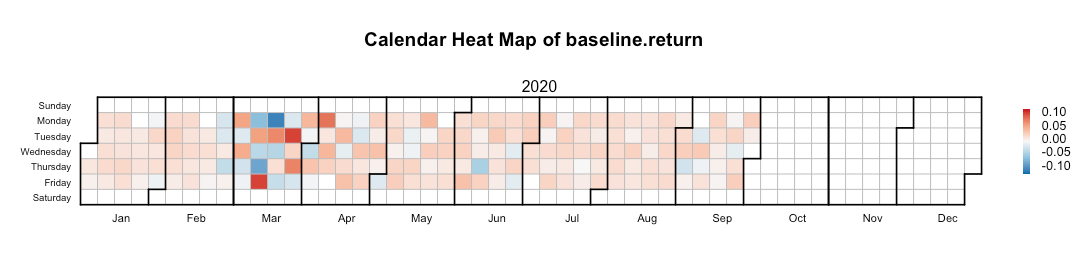

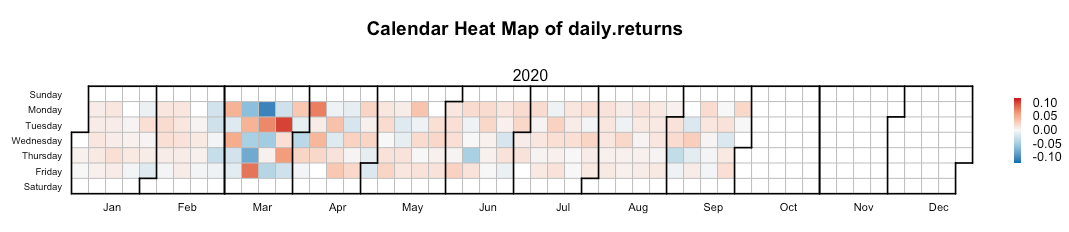

In [16]:
display_png(file="../Visualizations/2001_Heatmap_baseline.png", height=300, width=700)
display_png(file="../Visualizations/2001_Heatmap_Ra_Outperform.png", height=300, width=700)
display_png(file="../Visualizations/2007_Heatmap_baseline.png", height=300, width=700)
display_png(file="../Visualizations/2007_Heatmap_Ra_Outperform.png", height=300, width=700)
display_png(file="../Visualizations/2020_Heatmap_baseline.png", height=300, width=700)
display_png(file="../Visualizations/2020_Heatmap_Ra_Outperform.png", height=300, width=700)

### Findings

Six variables are significant at the 95% confidence interval:


* Trailing Company Returns 
* Trailing Company Volatility
* Is Finance Sector
* Is Real Estate
* Average interest rate
* average unemployment rate

Strong performance in the year leading up to the recessionary period was indicative of outperformance, as is stock volatility.  The finance an real estate sectors show outperformance during recessions.  As unemployment and interest rates rise, peformance decreases.  

### Challenges

There are several key challenges that must be overcome to make these results more robust and realistic:

1.  Limited Historical Data: as our access to historical S&P 500 data was limited, we could only evaluate three
recession periods. Further, within those recession periods, there were some individual stocks for which data was
unavailable (e.g. for the 2001 recession period, we only had data for 340 stocks in the S&P 500). We did our best
to mitigate this by using code to track the changes in the S&P 500 listed in wikipedia
2.  Limited Operational Performance Data: operational performance data (e.g. market cap, operating income,
profit margin) may have been useful in predicting resilience during downturns. However, access to this data
required significant investment
3.  Non-stationarity: long periods of time between recessions means the patterns we find in our training data
may simply no longer exist due to naturally changing market and macroeconomic dynamics
             

There were several compromises that were required in our analysis that potentially introduced bias into our analysis. For a proxy of market performance, we used the constituent stocks of the S&P 500 index. The index is value-weighted which means that the largest companies will have a disproportionate weight in the index. Although it is common practice to do this, there were some biases this introduced that were unavoidable. One of which was the fact that the industry composition of the index is not perfectly balanced. There are some industries that are heavily weighted, while there are some that have a relatively small weighting. The graphic below shows the industry makeup of the stocks that we considered:

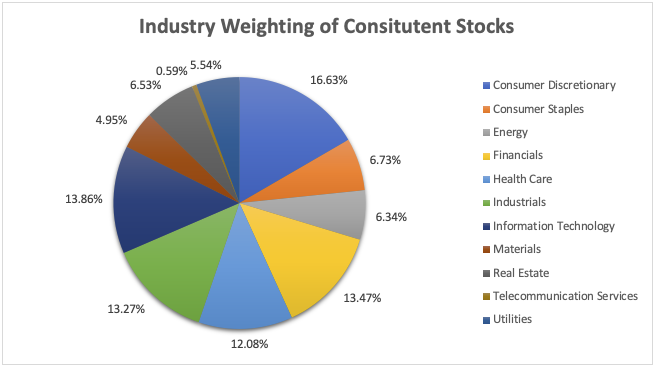

In [4]:
library(IRdisplay)
display_png(file="../Visualizations/sector.png", height=1000, width=700)

As can be seen, consumer discretionary dominates with 16.63% of the stocks belonging to that industry. Industries such as real estate, materials, & telecommunications consist of a dramatically smaller subset of the securities used. Consequently, for industries such as telecommunications, it is reasonable to assume that there is a degree of overfitting for stocks in that industry, and others with a relatively small composition. Although we could have arbitrarily added additional stocks to have a more balanced weighting between industries, this would have resulted in selection bias. 

Another natural challenge was due to the fact we are dealing with non-stationarity in our financial time series data. In financial data, this is the case when there are significantly different regimes within the data that may affect how our response variable changes. Although there are many ways the market dynamics changed drastically over the periods that we examined, the most noticeable difference that caught our attention was the difference in interest rates between the three recession periods. As shown in the table below, the interest rates were markedly different during the three periods.

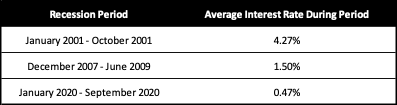

In [6]:
library(IRdisplay)
display_png(file="../Visualizations/Picture1.png", height=1000, width=500)

In addition to the biases that we had to contend with, there were issues with access to the appropriate financial data. Having issues on this end further exacerbated some of the previously mentioned problems. For the subsection of our data that included the Great Recession, we were only able to find 60% of the stocks that were in the S&P 500 at the beginning of that period. This inevitably lead to some overfitting for industries that were already thinly represented in the index.
This was also problematic as it prevented us from gaining access to firm specific financial data that we would have then used to compute profitability, liquidity, and leverage ratios. Before we realized that we could not get access to this data, one of our initial hypotheses was that firms with low leverage ratios (such as debt to equity ratio) would be resilient in recessions. It was a very difficult task to gain access to this information however, so we left this out altogether.

Although we used a logistic regression in the end to determine which types of stocks would outperform, we had different ideas initially. We wanted to replace this model with a k-means clustering model. The k-means model would still use the output from the Jensen’s alpha regression. With those results, our plan was to then find categories that distinguished between the groups of underperformers and outperformers and then see if there were any interesting commonalities between the subgroups that the algorithm developed.

As we went deeper into our exploratory data analysis, we noticed that there were some fundamental characteristics of some of our features that we wanted to use that made it difficult to implement this method. When we examined the price to book value ratio variable, we noticed that there was a very severe degree of skewness in its distribution as shown in the boxplot below:

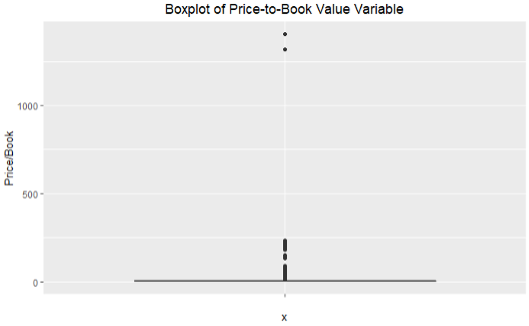

In [8]:
library(IRdisplay)
display_png(file="../Visualizations/Picture2.png", height=1000, width=700)

We delved deeper to see if there were any anomalies with the data that would warrant us removing the two outliers (which were L Brands & Philip Morris, with P/B ratios of 1403.38 & 1318.7, respectively) and there were not. 
Using the k-means clustering approach with this issue would have caused the cluster centers to disproportionately be moved by these points. Additionally, with the k-means approach, there would have been some margin for judgment when choosing the appropriate number of cluster centers. We ultimately felt that the logistic regression approach was more definitive, and had the better tools for variable selection, so we went with that approach instead.


## Future Direction

There are a number possible ways to continue this work, the most important being to acquire a longer history of data, and more stock specific data, like common equity factor exposures, to regress against.  Another important future direction would be to include the use of non-linear classifiers, or non-linear feature transformation as some patterns may be complicated. For instance, though we found that trailing performance/momentum is predictive of outperformance during a recession, perhaps the biggest outperformers could perform poorly if they are part of a bubble that has formed. Lastly, should a recession be upon us, it will be important to use that to validate our results.

The greatest priorities for our group if given more time and resources would have been to incorporate additional firm specific data into the analysis, look at additional time periods of economic downturns, and incorporate a sentiment factor into our analysis. 

The end result of our analysis was to include three periods of economic downturns that we calibrated our models on. Although this was the best that we could do with the prohibitive restrictions and resources needed to acquire additional data, including additional data points from more historical periods would have made our model more sound, and less susceptible to possible overfitting. 

Including firm specific data proved to be one of the most difficult endeavors for us. Without having access to proprietary databases, or sufficient financial resources, this data was unavailable, and our group was very dismayed by the valuable learning opportunities that were forgone because of this. Some of our inspiration for doing this came from the paper by Guan (2013) where company attributes relating to profitability, leverage, and accounting liquidity were used in his ranking metrics.  We would have liked to incorporate measures such as inventory turnover, debt to equity ratio, and profit margin.

In our initial meeting where we brainstormed and created mind maps of how to approach this problem, we thought that creating a sentiment factor each of the stocks would have been a powerful feature to include. Doing so would have required the application of natural language procession which would have been applied to reports of individual securities to derive an optimistic or pessimistic score for each stock. The score would have then been used as one of the cofactors for the logistic regression. Unfortunately, we were too time restricted to delve into this technique and apply it appropriately

Although recessions are the among the economic events that are often the most costly to investors, there are often other macroeconomic scenarios that can be very disadvantageous to investors that can prevent them from reaching their financial goals. If given more time, we would have liked to do additional stress tests to explore how we could make portfolios that also outperform during other anomalous market conditions. 

One additional scenario that we would have likely extended our analysis to would be periods of high market volatility. Periods of high market volatility can be very opportunistic for investors with very long investment horizons and an above average levels of risk tolerance. However, for investors that are on the opposite end of the spectrum such as those that are nearing retirement, there is far less ability to tolerate volatile market conditions given that these individuals need a high degree of certainty in the ending values of their portfolios so that they can properly plan for the drawdown of their funds. 

In this extension, we would have begun our analysis in much of the same way as before by looking at approximately the last one hundred years of market data. The main difference in this scenario is that we would use periods of anomalous market volatility instead of recession periods. This would likely be defined as periods where the volatility is above a pre-specified number of standard deviations from the average. Per usual, we would then run our linear regression to see which stocks were above a pre-specified percentile of performance based on Jensen’s alpha. We would subsequently perform a logistic regression as before to see if we could glean into insights that would make stocks more or less likely to outperform in such conditions.  


## Conclusion/Takeaways
Upon completion of this ambitious project, there were many important learning outcomes for us, and important practical applications of this exercise that we will be able to apply to our personal investment portfolios, and the portfolios of others that want to have an edge in turbulent markets. The main learning point that resonated with us through all of our team discussions was the fact that this undertaking was more of an art than a science. Although we had complex models at our disposal, the majority of the value add that we brought to this endeavor was from being able to discern between the strengths and weaknesses of the tools that were available and choose the best combination in-light of the problem that we were facing. Although there were some instances where imperfect information, or lack of information altogether lead us to situations that left us wanting to do more, we were mindful of the business problem with all of our decisions and were able to develop a model that all groups’ members have expressed interest in using in their personal lives.

We can summarize our key findings in two parts. From a macroeconomic level, rising unemployment rates & rising interest rates are indicative of outperformance. From a firm specific level, strong performance and volatility in the period leading to a downturn in addition to being classified as a real estate or financials company are conducive to outperformance. These findings are powerful and have immediate relevance given the growing level of hearsay concerning a potential forthcoming economic downturn. 


## Sources



1.  Woszczyk K, 2019, ‘Do mutual funds invest in recession-proof industries prior to
crisis?’, MSc thesis, Erasmus University Rotterdam, Rotterdam [(link)](https://thesis.eur.nl/pub/48135/Thesis-final-K-Woszczyk-25.07.pdf)
1.  Ozkan F C, Xiong Y, 2009, ‘Wise Investing: Analysis of the recession-proof sin
stocks’, MBA thesis, Simon Fraser University, British Columbia [(link)](http://summit.sfu.ca/item/709)
1.  Tidyquant, source of stock data (via Yahoo) and macroeconomic times series (via
Fred) [(link)](https://cran.r-project.org/web/packages/tidyquant/vignettes/TQ05-performance-analysis-with-tidyquant.html)
1.  Kaggle, guidance for performing S&P 500 Analysis in R [(link)](https://www.kaggle.com/code/paytonfisher/s-p-500-analysis-using-r/notebook)
1.  Schwab, ‘Macro-economic factors of fundamental analysis’ [(link)](https://www.cnbc.com/advertorial/2018/06/11/macro-economic-factors-of-fundamental-analysis.html)
1.  Stijn Claessens, M. Ayhan Kose, and Marco E. Terrones, 2008, ‘What Happens During Recessions, Crunches and Busts?’ [(link)](https://www.imf.org/external/pubs/ft/wp/2008/wp08274.pdf)
1.  U.S. Bureau of Labor Statistics, Unemployment Rate [UNRATE], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/UNRATE, July 18, 2022 [(link)](https://fred.stlouisfed.org/series/UNRATE)
1.  Board of Governors of the Federal Reserve System (US), Federal Funds Effective Rate [FEDFUNDS], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/FEDFUNDS, July 18, 2022 [(link)](https://fred.stlouisfed.org/series/FEDFUNDS)
1.  Hamilton, James, Dates of U.S. recessions as inferred by GDP-based recession indicator [JHDUSRGDPBR], retrieved from FRED, Federal Reserve
Bank of St. Louis; https://fred.stlouisfed.org/series/JHDUSRGDPBR, July 18, 2022 [(link)](https://fred.stlouisfed.org/series/JHDUSRGDPBR)

## Code

### Getting Data From Wiki For The List of SP500 Institution Historically

#### Load dependencies

In [ ]:
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, rvest)
library(dplyr)
library(readr)

#### This is where the input  of the list of SP500 companies from wiki 

In [ ]:
wikispx <- read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
currentconstituents <- wikispx %>%
  html_node('#constituents') %>%
  html_table(header = TRUE)

#### currentconstituents

In [ ]:
spxchanges <- wikispx %>%
  html_node('#changes') %>%
  html_table(header = FALSE, fill = TRUE) %>%
  filter(row_number() > 2) %>% # First two rows are headers
  `colnames<-`(c('Date','AddTicker','AddName','RemovedTicker','RemovedName','Reason')) %>%
  mutate(Date = as.Date(Date, format = '%B %d, %Y'),
         year = year(Date),
         month = month(Date))

#### Start at the current constituents...

In [ ]:
currentmonth <- as.Date(format(Sys.Date(), '%Y-%m-01'))
monthseq <- seq.Date(as.Date('1969-04-01'), currentmonth, by = 'month') %>% rev()

spxstocks <- currentconstituents %>% mutate(Date = currentmonth) %>% select(Date, Ticker = Symbol, Name = Security, Sector = `GICS Sector`)
lastrunstocks <- spxstocks

#### Iterate through months, working backwards to get the institutions changed

In [ ]:
for (i in 2:length(monthseq)) {
  d <- monthseq[i]
  y <- year(d)
  m <- month(d)
  changes <- spxchanges %>% 
    filter(year == year(d), month == month(d)) 
      # Remove added tickers (we're working backwards in time, remember)
      tickerstokeep <- lastrunstocks %>% 
        anti_join(changes, by = c('Ticker' = 'AddTicker')) %>%
        mutate(Date = d)

      # Add back the removed tickers...
      tickerstoadd <- changes %>%
        filter(!RemovedTicker == '') %>%
        transmute(Date = d,
                  Ticker = RemovedTicker,
                  Name = RemovedName)

      thismonth <- tickerstokeep %>% bind_rows(tickerstoadd)
      spxstocks <- spxstocks %>% bind_rows(thismonth)  

      lastrunstocks <- thismonth
}

#### Then we filter the final dataset to the period that we would like to include in our analysis and combined them to get the final dataset that we output to a csv file that is called "sp500_bear_periods.csv"

### Manipulate, cleansing, and use data for detail analysis
#### Categorize market cap 

In [ ]:
sp500_w_details <- sp500_w_details %>%
  mutate(cap_category = ifelse(sp500_w_details$`Market Cap` > 10000000000, 'Large Cap', 
                               ifelse(sp500_w_details$`Market Cap` < 2000000000, 'Small Cap', 'Mid Cap')))

#### We get the 8 periods data (1969, 1973, 1979, 1981, 1989, 2001, 2007, 2020)
#### Then, we calculate the stock return monthly using the tidyverse split, apply, combine framework, we can mutate groups of stocks by first “grouping” with group_by and then applying a mutating function using tq_transmute. We use the quantmod function periodReturn as the mutating function. We pass along the arguments period = "monthly" to return the results in monthly periodicity. Last, we use the col_rename argument to rename the output column for each bear market period and also baseline (^GSPC) for each period as well.
#### Below is a sample for 1971 period

In [ ]:
for (value in symb_2001) {
  curr <- subset(RaRb_single_portfolio_2001, symbol==value)
  std <- round(sd(curr$Ra)*100,2) 
  mean <- round(mean(curr$Ra)*100,2)
  std_2001[nrow(std_2001) + 1,] <- c(value, std, mean, 2001)
}
Ra_1971<- tickers_1971 %>%
  tq_get(get  = "stock.prices",
         from = "1969-04-01",
         to = "1971-01-01") %>%
  group_by(symbol) %>%
  tq_transmute(select     = adjusted, 
               mutate_fun = periodReturn, 
               period     = "monthly", 
               col_rename = "Ra") 
               
baseline_1971 <- benchmarks %>%
  tq_get(get  = "stock.prices",
         from = "1969-04-01",
         to = "1971-01-01") %>%
  tq_transmute(select     = adjusted, 
               mutate_fun = periodReturn, 
               period     = "monthly", 
               col_rename = "Rb") 

#### Then, we join the dfs and calculate CAPM  table. We find that the data for most are the periods are extremely small and are not worth to run the regression model, so we get the top 3 periods to run the model (2001, 2007, 2020) and retrieve the Alpha
#### Example of 1 period:

In [ ]:
RaRb_single_portfolio_2001 <- left_join(Ra_2001,
                                        baseline_2001,
                                        by = "date")

RaRb_capm_2001 <- RaRb_single_portfolio_2001 %>%
  tq_performance(Ra = Ra, 
                 Rb = Rb, 
                 performance_fun = table.CAPM)

#### We categorize the outperformance based on the top 30 percentile (1: outperform, 0: underperform)

In [ ]:
thirtyp_threshold_2001 <- quantile(as.numeric(RaRb_capm_2001$Alpha), probs = 0.7)
RaRb_capm_2001$performance <- ifelse(RaRb_capm_2001$Alpha >= thirtyp_threshold_2001, 1, 0)
RaRb_capm_2001 <- RaRb_capm_2001[keep]

#### We run to get the stock monthly return for the last 12 months prior to each bear market periods and calculate the average standard deviation and average return for these periods

In [ ]:
std_2001 <- data.frame(matrix(ncol = 4, nrow = 0))

#### Since we already retrieve the macroeconomic factors data from FRED, we use them to calculate average interest rate and unemployment rate
#### Example of 1 period:

In [ ]:
colnames(eco_factors) <- c('date', 'FEDFUNDS', 'GDP', 'UNRATE', 'PAYEMS', 'ICSA', 'CPIAUCSL', 'USREC')
eco_factors$date <- as.Date(eco_factors$date, format = "%Y-%m-%d")

eco_factors_2001 <- filter(eco_factors, date>="2001-01-02" & date<="2001-10-02")
RaRb_capm_comb_2001$interest_mean <- round(mean(eco_factors_2001$FEDFUNDS),1)
RaRb_capm_comb_2001$unemp_mean <- round(mean(eco_factors_2001$UNRATE),1)

#### Then, we join the sector to our main dataset. We also drop any NA rows as some tickers, we won't be able to get the sector info on them. This is one of the challenges of obtaining the data available for our analysis.
#### Example of 1 period:

In [ ]:
RaRb_capm_comb_final_2001 <- left_join(RaRb_capm_comb_2001, 
                                       tickers_w_symbol,
                                       by = "symbol")
RaRb_capm_comb_final_2001 <- RaRb_capm_comb_final_2001 %>% drop_na()
RaRb_capm_comb_final_2001$sector <- as.factor(RaRb_capm_comb_final_2001$sector)

RaRb_capm_comb_final_2001$LMT_std <- as.double(RaRb_capm_comb_final_2001$LMT_std)
RaRb_capm_comb_final_2001$mean <- as.double(RaRb_capm_comb_final_2001$mean)

#### While we run the logistic regression models, we realize that we need to reduce the sectors to find the one that has statistical significant. We convert our sector to column with binary values, so we can use them to continue run the logistic regression models. Our models sector selection downs to 3 sectors: Finance, Real Estate and Industrial.

In [ ]:
combine <- bind_rows(RaRb_capm_comb_final_2001, RaRb_capm_comb_final_2007, RaRb_capm_comb_final_2020)
combine_converted <- combine %>% 
  mutate(con_dis = ifelse(sector == "Consumer Discretionary", 1, 0)) %>%
  mutate(fin = ifelse(sector == "Finance", 1, 0)) %>%
  mutate(inds = ifelse(sector == "Industrials", 1, 0)) %>%
  mutate(real_est = ifelse(sector == "Real Estate", 1, 0)) %>%
  mutate(tech = ifelse(sector == "Technology", 1, 0)) %>%
  mutate(tele = ifelse(sector == "Telecommunications", 1, 0)) 

#### Logistic Regression models that we run

In [ ]:
logistic<- glm(performance ~ LMT_std + mean + interest_mean + unemp_mean + sector, data=combine, family=binomial(link='logit'))

logistic_conv <- glm(performance ~ LMT_std + mean + interest_mean + unemp_mean + con_dis + fin + inds
                     + real_est + tech + tele, data=combine_converted, family=binomial(link='logit'))

logistic_conv_revise <- glm(performance ~ LMT_std + mean + interest_mean + unemp_mean + fin + inds
                     + real_est, data=combine_converted, family=binomial(link='logit'))

logistic_conv_revise1 <- glm(performance ~ LMT_std + mean + interest_mean + unemp_mean + fin
                            + real_est, data=combine_converted, family=binomial(link='logit'))

#### We output the model summary which we use to find the impact of each factor on the outperformance of these tickers during each period